## Similaridade de Projetos Baseado nos itens utilizados

Lendo os dados e salvando na matriz X.
As features utilizadas neste projeto são: 
- IdPRONAC
- Item
- Quantidade(Proposta)
- Ocorrencia(Proposta)
- QtdeDias(Proposta)
- ValorUnitario(Proposta)
- Justificativa(Proposta)


In [1]:
import pandas as pd
import numpy as np

Data = pd.read_csv('Salic_Data.csv')
Data.columns = ['IdPRONAC', 'CgcCpf', 'AnoProjeto', 'Sequencial', 'idPlanilhaEtapa', 'UF', 'Municipio', 'Item', 'Unidade', 'Quantidade(Proposta)', 'Ocorrencia(Proposta)', 'QtdeDias(Proposta)', 'ValorUnitario(Proposta)', 'Justificativa(Proposta)', 'Quantidade(Projeto)', 'Ocorrencia(Projeto)', 'QtdeDias(Projeto)', 'ValorUnitario(Projeto)', 'Justificativa(Parecista)', 'Produto']

X = Data[['IdPRONAC', 'Item', 'Quantidade(Proposta)', 'Ocorrencia(Proposta)', 'QtdeDias(Proposta)', 'ValorUnitario(Proposta)', 'Justificativa(Proposta)']]

Variáveis úteis utilizadas ao longo do projeto

- ConjuntoDeItens    = conjunto de itens utilizados em todos os projetos.
- ConjuntoDeProjetos = lista do pronac de todos os projetos.
- featureNameToIndex = usado para converter o nome da coluna para o índex da matriz associado.

In [2]:
ConjuntoDeItens = list(set(X['Item']))
ConjuntoDeProjetos = list(set(X['IdPRONAC']))

# FEATURE INDICES
featureNameToIndex = {featureName: index for index, featureName in enumerate(X)}


####  Processamento de dados.

Agrupamento dos itens de cada projeto, considerando também a quantidade.

Criando um dicionário **pronac_itens_dict**

- Key   ->   pronac
- Value -> [item, quantidade] 

In [3]:
from collections import defaultdict
pronac_itens_dict = defaultdict(list)
X_values = X.values

for index, item  in enumerate(X_values):
    pronac_itens_dict[item[featureNameToIndex['IdPRONAC']]].append([item[featureNameToIndex['Item']], item[featureNameToIndex['Quantidade(Proposta)']]*item[featureNameToIndex['Ocorrencia(Proposta)']]*item[featureNameToIndex['QtdeDias(Proposta)']]])

#### Une itens similares e soma quantidade.
- Key   ->   pronac
- Value -> Dicionário{item, quantidade}  

In [4]:
pronac_itens_compressed_dict = {}
for key_pronac, value_itens in pronac_itens_dict.items():
    item_value_dict = {}
    for value in value_itens:
        if value[0] in item_value_dict:
            item_value_dict[value[0]] = item_value_dict[value[0]] + value[1]
        else:
            item_value_dict[value[0]] = value[1]
#     print(key_pronac)
#     print(item_value_dict)
    pronac_itens_compressed_dict[key_pronac] = item_value_dict

#### Criando matriz com todos os dados

    | Pronac 1 | Pronac 2 | Pronac 3 |
        
    |  Item 1  |  Item 1  |  Item 1  |
    |  Item 2  |  Item 2  |  Item 2  |
    |  Item 3  |  Item 3  |  Item 3  |
    ...
    


In [5]:
def buildProjetItemsArray(projectItems, allItems):
    items_arrays = np.zeros(len(allItems))
    for index, item in enumerate(allItems):
        if (item in projectItems):
            items_arrays[index] = 1
    return list(items_arrays)
            

projectsItemsMatrix = []
for index, pronacID in enumerate(ConjuntoDeProjetos):   
    x = buildProjetItemsArray(pronac_itens_compressed_dict[pronacID],ConjuntoDeItens)
    projectsItemsMatrix.append(x)
#     # Testing vector
#     print('\n', pronacID, '\n***********\n')
#     for i in range(0, len(ConjuntoDeItens)):
#         if(x[i] == 1):
#             print(ConjuntoDeItens[i])
#     print(pronac_itens_compressed_dict[pronacID])

#     # Using less data to train faster  
    if (index == 500):
        break;
    
#print(projectsItemsMatrix)


### K-MEANS + PCA

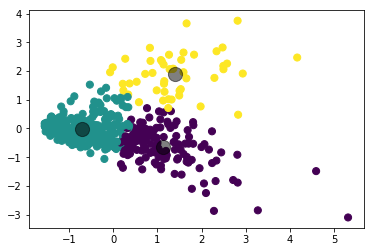

In [6]:
X = projectsItemsMatrix

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=8)  # random_state: 2, 5, *8*
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
kmeans_centers = kmeans.cluster_centers_

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
y_pca = pca.transform(X) 
#y_pca = pca.fit_transform(X)

plt.scatter(y_pca[:, 0], y_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')


centers_pca = pca.transform(kmeans_centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, alpha=0.5);
plt.show();

### K-MEANS + TSNE

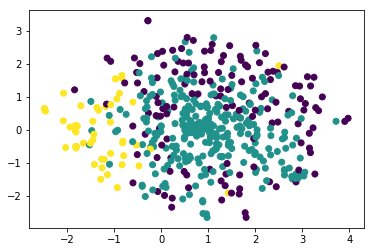

In [7]:
X = projectsItemsMatrix

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=8) # random_state: 2, 5, *8*
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# print(y_kmeans)

from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=70, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(X)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y_kmeans, cmap='viridis')

plt.show();

### K-MEANS + TSNE + PCA

Utilizando PCA antes de TSNE

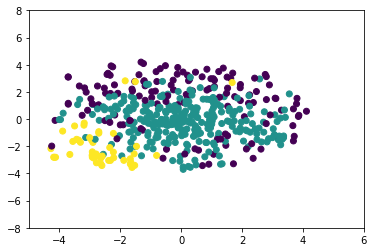

In [8]:
# K-MEANS + PCA + T-SNE
# PCA BEFORE T-SNE

X = projectsItemsMatrix

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=8) # random_state: 2, 5, *8*
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(X)
y_pca = pca.transform(X) 


from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=70, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(y_pca)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y_kmeans, cmap='viridis')
plt.xlim(-5, 6)
plt.ylim(-8, 8)

plt.show();


### PCA + K-MEANS

- Reduzindo dimensões (PCA) antes de gerar os clusters (KMEANS). 

- Plotando dados com TSNE.

- OBJETIVO: Verificar se há melhoria na performance. Comparar como outro cluster para observar a relevância das features menos significativas.

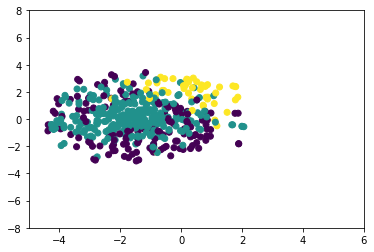

In [9]:
X = projectsItemsMatrix

from sklearn.decomposition import PCA
pca = PCA(n_components=200)
pca.fit(X)
y_pca = pca.transform(X) 



import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=8) # random_state: 2, 5, *8*
kmeans.fit(y_pca)
y_kmeans = kmeans.predict(y_pca)



from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=70, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(y_pca)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y_kmeans, cmap='viridis')
plt.xlim(-5, 6)
plt.ylim(-8, 8)

plt.show();



### Silhouette para avaliar clusters kmeans

### Alternativas ao K-means

#### DBSCAN

- Not good for high dimension data.

- Identified a single cluster

Estimated number of clusters: 1


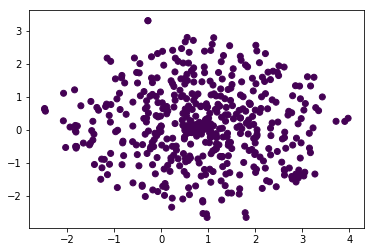

In [10]:
X = projectsItemsMatrix

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=27.0) # random_state: 2, 5, *8*
y_dbscan = dbscan.fit_predict(X)


n_clusters_ = len(set(y_dbscan))
print('Estimated number of clusters: %d' % n_clusters_)


from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=70, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(X)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y_dbscan, cmap='viridis')

plt.show();

#### Expectation–Maximization (EM) Clustering using Gaussian Mixture Models (GMM)

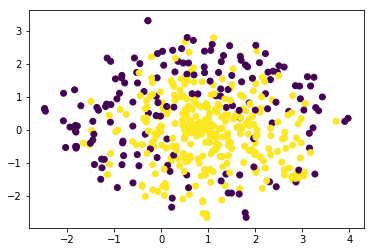

In [11]:
X = projectsItemsMatrix

import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture


gaussianMixture = GaussianMixture(n_components=2, covariance_type='full')
gaussianMixture.fit(X)
y_gm = gaussianMixture.predict(X)


n_clusters_ = len(set(y_gm))


from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=70, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(X)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y_gm, cmap='viridis')

plt.show();

#### SpectralClustering

- Makes no assumptions on the shapes of clusters, can handle intertwined spirals, etc.
- EM or the like require an iterative process to find local minima nad multiple restarts.


Estimated number of clusters: 8


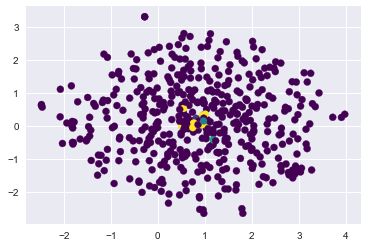

In [38]:
X = projectsItemsMatrix

import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering


# spectralClustering = SpectralClustering()
# y_sc = spectralClustering.fit(X)
# y_sc = spectralClustering.(X)
# print(y_sc)

# similarity = np.exp(-beta * distance / distance.std())

sc = SpectralClustering()
y_sc = sc.fit_predict(X)



n_clusters_ = len(set(y_sc))
print('Estimated number of clusters: %d' % n_clusters_)




from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=70, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(X)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y_sc, cmap='viridis')

plt.show();

### Testing clusters on fake data
NÃO tem relação com o projeto.

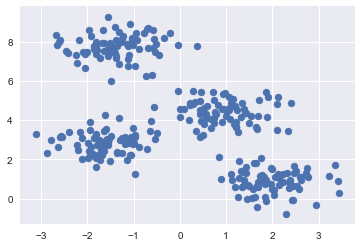

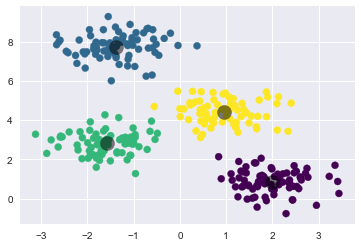

In [12]:
# 2D Data Clustering
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=50);
plt.show();

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show();

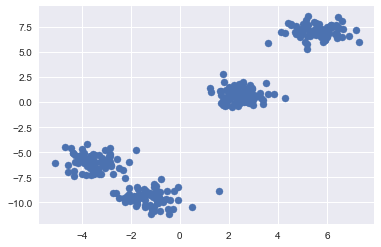

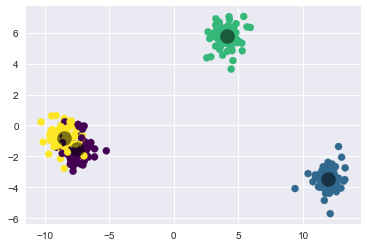

In [13]:
# K-Means + PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_features=5, n_samples=300, centers=4,
                       cluster_std=0.70, random_state=2)

plt.scatter(X[:, 0], X[:, 1], s=50);
plt.show();
# plt.scatter(X[:, 2], X[:, 3], s=50);
# plt.show();

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
y_pca = pca.transform(X) 

plt.scatter(y_pca[:, 0], y_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, alpha=0.5);
plt.show();


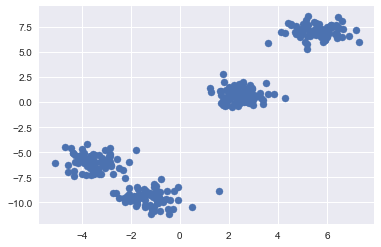

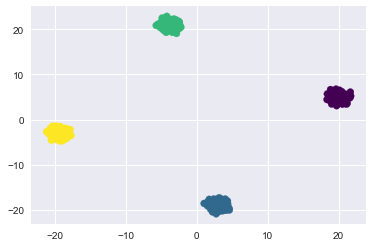

In [14]:
# K-Means + T-SNE
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_features=5, n_samples=300, centers=4,
                       cluster_std=0.70, random_state=2)

plt.scatter(X[:, 0], X[:, 1], s=50);
plt.show();
# plt.scatter(X[:, 2], X[:, 3], s=50);
# plt.show();

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)



from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=50, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(X)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y_kmeans, cmap='viridis')


plt.show();

